In [60]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import jax
from src import CARPoolEmulator, CARPoolSimulations
import scienceplots
plt.style.use(['science', 'no-latex', 'notebook', 'grid'])

# Extract the data from files

In [61]:
def extract_params(line):
    params = line.split(' ')[1:29]
    params.append(line.split(' ')[35])
    return np.array(params, dtype='float')

In [62]:
with open('Data/PARAMS.txt', 'r') as file:
    lines = file.readlines()
theta_raw = np.array([extract_params(line) for line in lines])

In [63]:
import pandas as pd
theta = theta_raw.copy()
param_info = pd.read_csv('Data/SB28_param_minmax.csv')
for i, t in enumerate(theta_raw[:, :-1].T):
    if bool(param_info['LogFlag'][i]):
        theta[:, i] = np.log10(theta_raw[:, i])

In [64]:
def BS_organizer(N, thetas):
    theta_S = []
    theta_B = []
    for i, theta in zip(N, thetas):
        if (i//128)%2 ==0:
            theta_B.append(theta)
        elif (i//128)%2 ==1:
            theta_S.append(theta)
        else:
            raise Exception("Somethings totally wrong")
    return np.array(theta_B), np.array(theta_S)

def BS_matcher(N_B, N_S, base, surrogate):
    bases, surrogates = [], []
    for i, b in enumerate(N_B):
        if b+128 in N_S:
            bases.append(i)
            j = np.where(b+128 == N_S)[0][0]
            surrogates.append(j)
    base = np.concatenate((base[np.array(bases)], base[np.delete(np.arange(len(base)), bases)]))
    surrogate = np.concatenate((surrogate[np.array(surrogates)], surrogate[np.delete(np.arange(len(surrogate)), surrogates)]))
    return base, surrogate

In [150]:
# Organize the data a bit

data = np.load('Data/sims.npz')
usable_indices = np.nonzero(data['Y'])

Ysz      = np.log10(data['Y'][usable_indices])
Mass     = np.log10(data['M'][usable_indices]*1e10)
zoom_num = data['N'][usable_indices]

usable_theta        = theta[zoom_num]
usable_theta[:, -1] = Mass
usable_theta_normalized = (usable_theta - usable_theta.min(axis=0)) / (usable_theta.min(axis=0) - usable_theta.max(axis=0)) + 1 #Normalizes to between 0 and 1

# usable_theta_normalized = usable_theta_normalized[zoom_num < 256]
# Ysz = Ysz[zoom_num < 256]
# zoom_num = zoom_num[zoom_num<256]
usable_theta_normalized = usable_theta_normalized[zoom_num > 256]
Ysz = Ysz[zoom_num > 256]
zoom_num = zoom_num[zoom_num>256]

theta_B, theta_S  = BS_organizer(zoom_num, usable_theta_normalized) 
Q_B, Q_S          = BS_organizer(zoom_num, Ysz) 
N_B, N_S          = BS_organizer(zoom_num,zoom_num)
Q_B, Q_S          = BS_matcher(N_B, N_S, Q_B, Q_S)
theta_B, theta_S  = BS_matcher(N_B, N_S, theta_B, theta_S)

# Create emulator

In [148]:
# Create simulation objects and surrogate objects
sims = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = theta_B  ;  sims.quantities  = Q_B
surrs.parameters = theta_S  ;  surrs.quantities = Q_S

#Build an emulator object (this generates the kernels which you can find in the CARPoolKernels file) 
emu = CARPoolEmulator.Emulator(sims, surrs)

In [149]:
params = {"log_scaleV"   :3*np.ones(emu.param_dimensions),
        "log_scaleX" :0*np.ones(emu.param_dimensions),
        "log_scaleW" : 3*np.ones(emu.param_dimensions),
        "log_scaleM" :1*np.ones(emu.param_dimensions),
        "log_ampV"   :0.0*np.ones(emu.param_dimensions),
        "log_ampW"   :0.0*np.ones(emu.param_dimensions),
        "log_ampX"   :0.0*np.ones(emu.param_dimensions),                
        "log_deltaP" :0*np.ones(emu.param_dimensions),
        "log_jitterV":-2.0,
        "log_jitterW":-2.0,
        "log_mean"   :-1.0}

best_params = emu.train(params,learning_rate=1e-5, max_iterations=100)

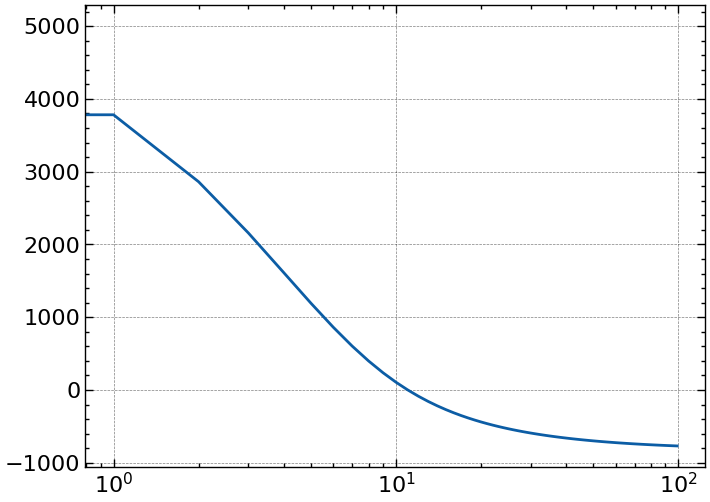

In [138]:
plt.semilogx(emu.losses[-1])

In [157]:
# Lets read in only the most massive halo
testdata = np.load('Data/random_1_SB28.npz')
usable_data = np.nonzero(testdata['Y'])[0]
Y_mean = np.log10(testdata['Y'][usable_data, 0])
Mass = np.log10(testdata['M'][usable_data, 0]*1e10)

# Mass = (Mass - Mass.min())/(Mass.max())

test_params = np.load('../Data/SB28_params.npy')[usable_data, :]
params_ =pd.read_csv('Data/SB28_param_minmax.csv')

multithetatest = np.vstack((test_params.T, Mass.T)).T
# X = params
for i, Xi in enumerate(multithetatest.T[:-1]):
    if params_['LogFlag'][i] == 1:
        multithetatest[:, i] = np.log10(multithetatest[:, i])
multithetatest = (multithetatest -  usable_theta.min(axis=0)) / (usable_theta.min(axis=0) - usable_theta.max(axis=0)) + 1
# X = X[:, :-1]

In [140]:
MCP2, VCP2 = emu.predict(multithetatest)

In [141]:
np.mean(np.diag(VCP)**0.5) / np.mean(np.diag(VCP2)**0.5)

1.4212477585274939

Text(0, 0.5, 'Counts')

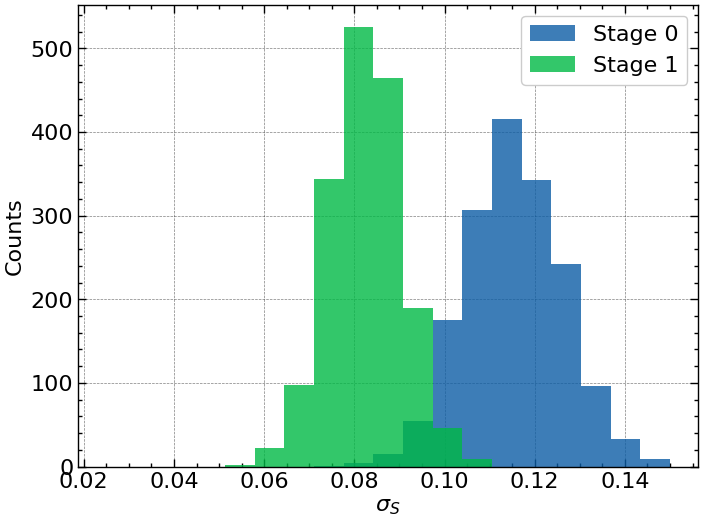

In [220]:
_ = plt.hist(np.diag(VCP)**0.5, bins = np.linspace(0.025, 0.15, 20), alpha=0.8, label='Stage 0')
_ = plt.hist(np.diag(VCP2)**0.5,bins = np.linspace(0.025, 0.15, 20), alpha=0.8, label='Stage 1')
plt.legend()
plt.xlabel(r'$\sigma_S$')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

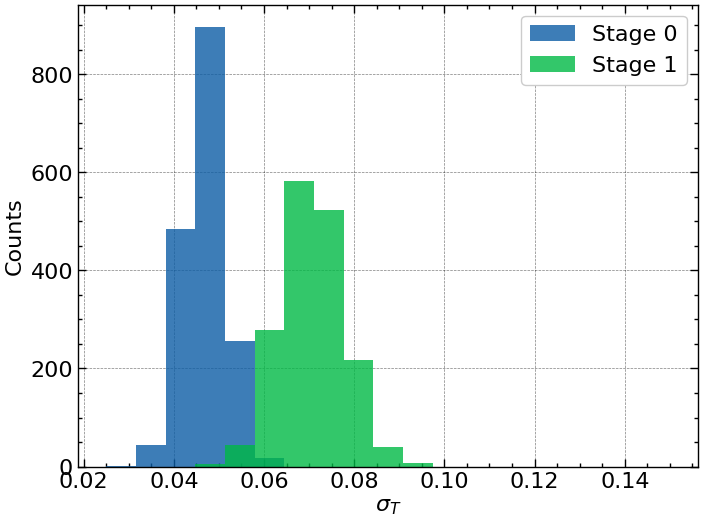

In [149]:
_ = plt.hist(np.diag(VCP)**0.5, bins = np.linspace(0.025, 0.15, 20), alpha=0.8, label='Stage 0')
_ = plt.hist(np.diag(VCP2)**0.5,bins = np.linspace(0.025, 0.15, 20), alpha=0.8, label='Stage 1')
plt.legend()
plt.xlabel(r'$\sigma_T$')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

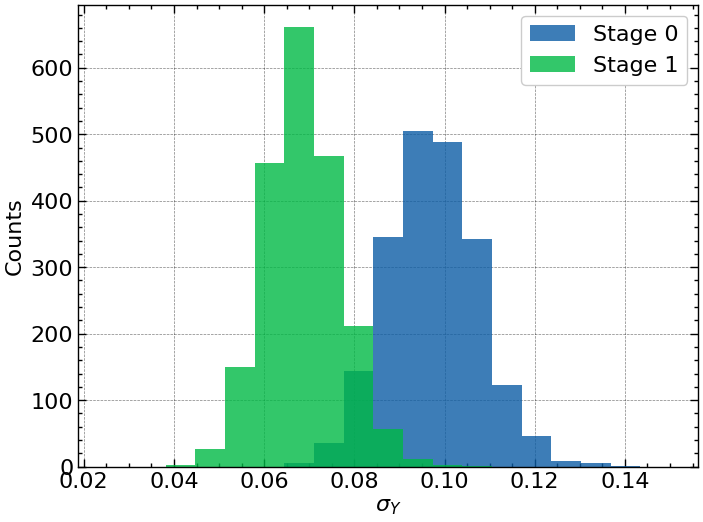

In [159]:
_ = plt.hist(np.diag(VCP)**0.5, bins = np.linspace(0.025, 0.15, 20), alpha=0.8, label='Stage 0')
_ = plt.hist(np.diag(VCP2)**0.5,bins = np.linspace(0.025, 0.15, 20), alpha=0.8, label='Stage 1')
plt.legend()
plt.xlabel(r'$\sigma_Y$')
plt.ylabel('Counts')

In [151]:
next_data, _ = emu.predict(theta_B)
next_surrogate_data, _ = emu.predict(theta_S)
emu.Simulations.update(theta_B, next_data)
emu.Surrogates.update(theta_S, next_surrogate_data)
emu.train(params,learning_rate=1e-5, max_iterations=100)
MCP_pred, VCP_pred = emu.predict(multithetatest)

In [152]:
def gauss(params, x):
    A, sigma, mu = params
    return A * np.exp(-0.5 * (x-mu)**2 / sigma**2)
def loss(params, x, y):
    return 1/len(y) * np.sum((gauss(params, x) - y)**2)

In [153]:
from scipy.optimize import minimize

Text(0, 0.5, 'Counts')

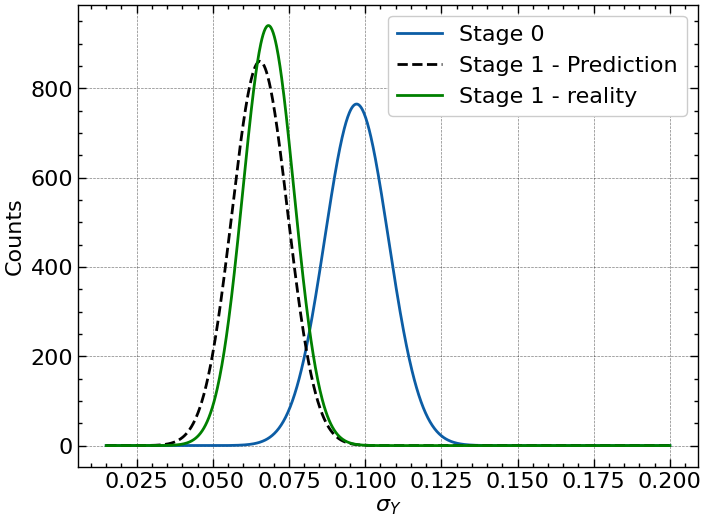

In [154]:
bins = np.linspace(0.015, 0.2, 20)

hist, _ = np.histogram(np.diag(VCP)**0.5, bins =bins)
fit = minimize(loss, x0=(500, 0.1, 0.01), args=( (bins[1:] - 0.5*np.median(np.diff(bins))), hist))
plt.plot(np.linspace(bins[0], bins[-1], 1000), gauss(fit.x, np.linspace(bins[0], bins[-1], 1000)), label='Stage 0')

hist, _ = np.histogram(np.diag(VCP_pred)**0.5, bins =bins)
fit = minimize(loss, x0=(600, 0.065, 0.01), args=( (bins[1:] - 0.5*np.median(np.diff(bins))), hist))
plt.plot(np.linspace(bins[0], bins[-1], 1000), gauss(fit.x, np.linspace(bins[0], bins[-1], 1000)),label='Stage 1 - Prediction', color='k', ls='--')

hist, _ = np.histogram(np.diag(VCP2)**0.5, bins =bins)
fit = minimize(loss, x0=(600, 0.065, 0.01), args=( (bins[1:] - 0.5*np.median(np.diff(bins))), hist))
plt.plot(np.linspace(bins[0], bins[-1], 1000), gauss(fit.x, np.linspace(bins[0], bins[-1], 1000)),  label='Stage 1 - reality', color='green')

plt.legend()
plt.xlabel(r'$\sigma_Y$')
plt.ylabel('Counts')

In [155]:
from scipy.stats import binned_statistic

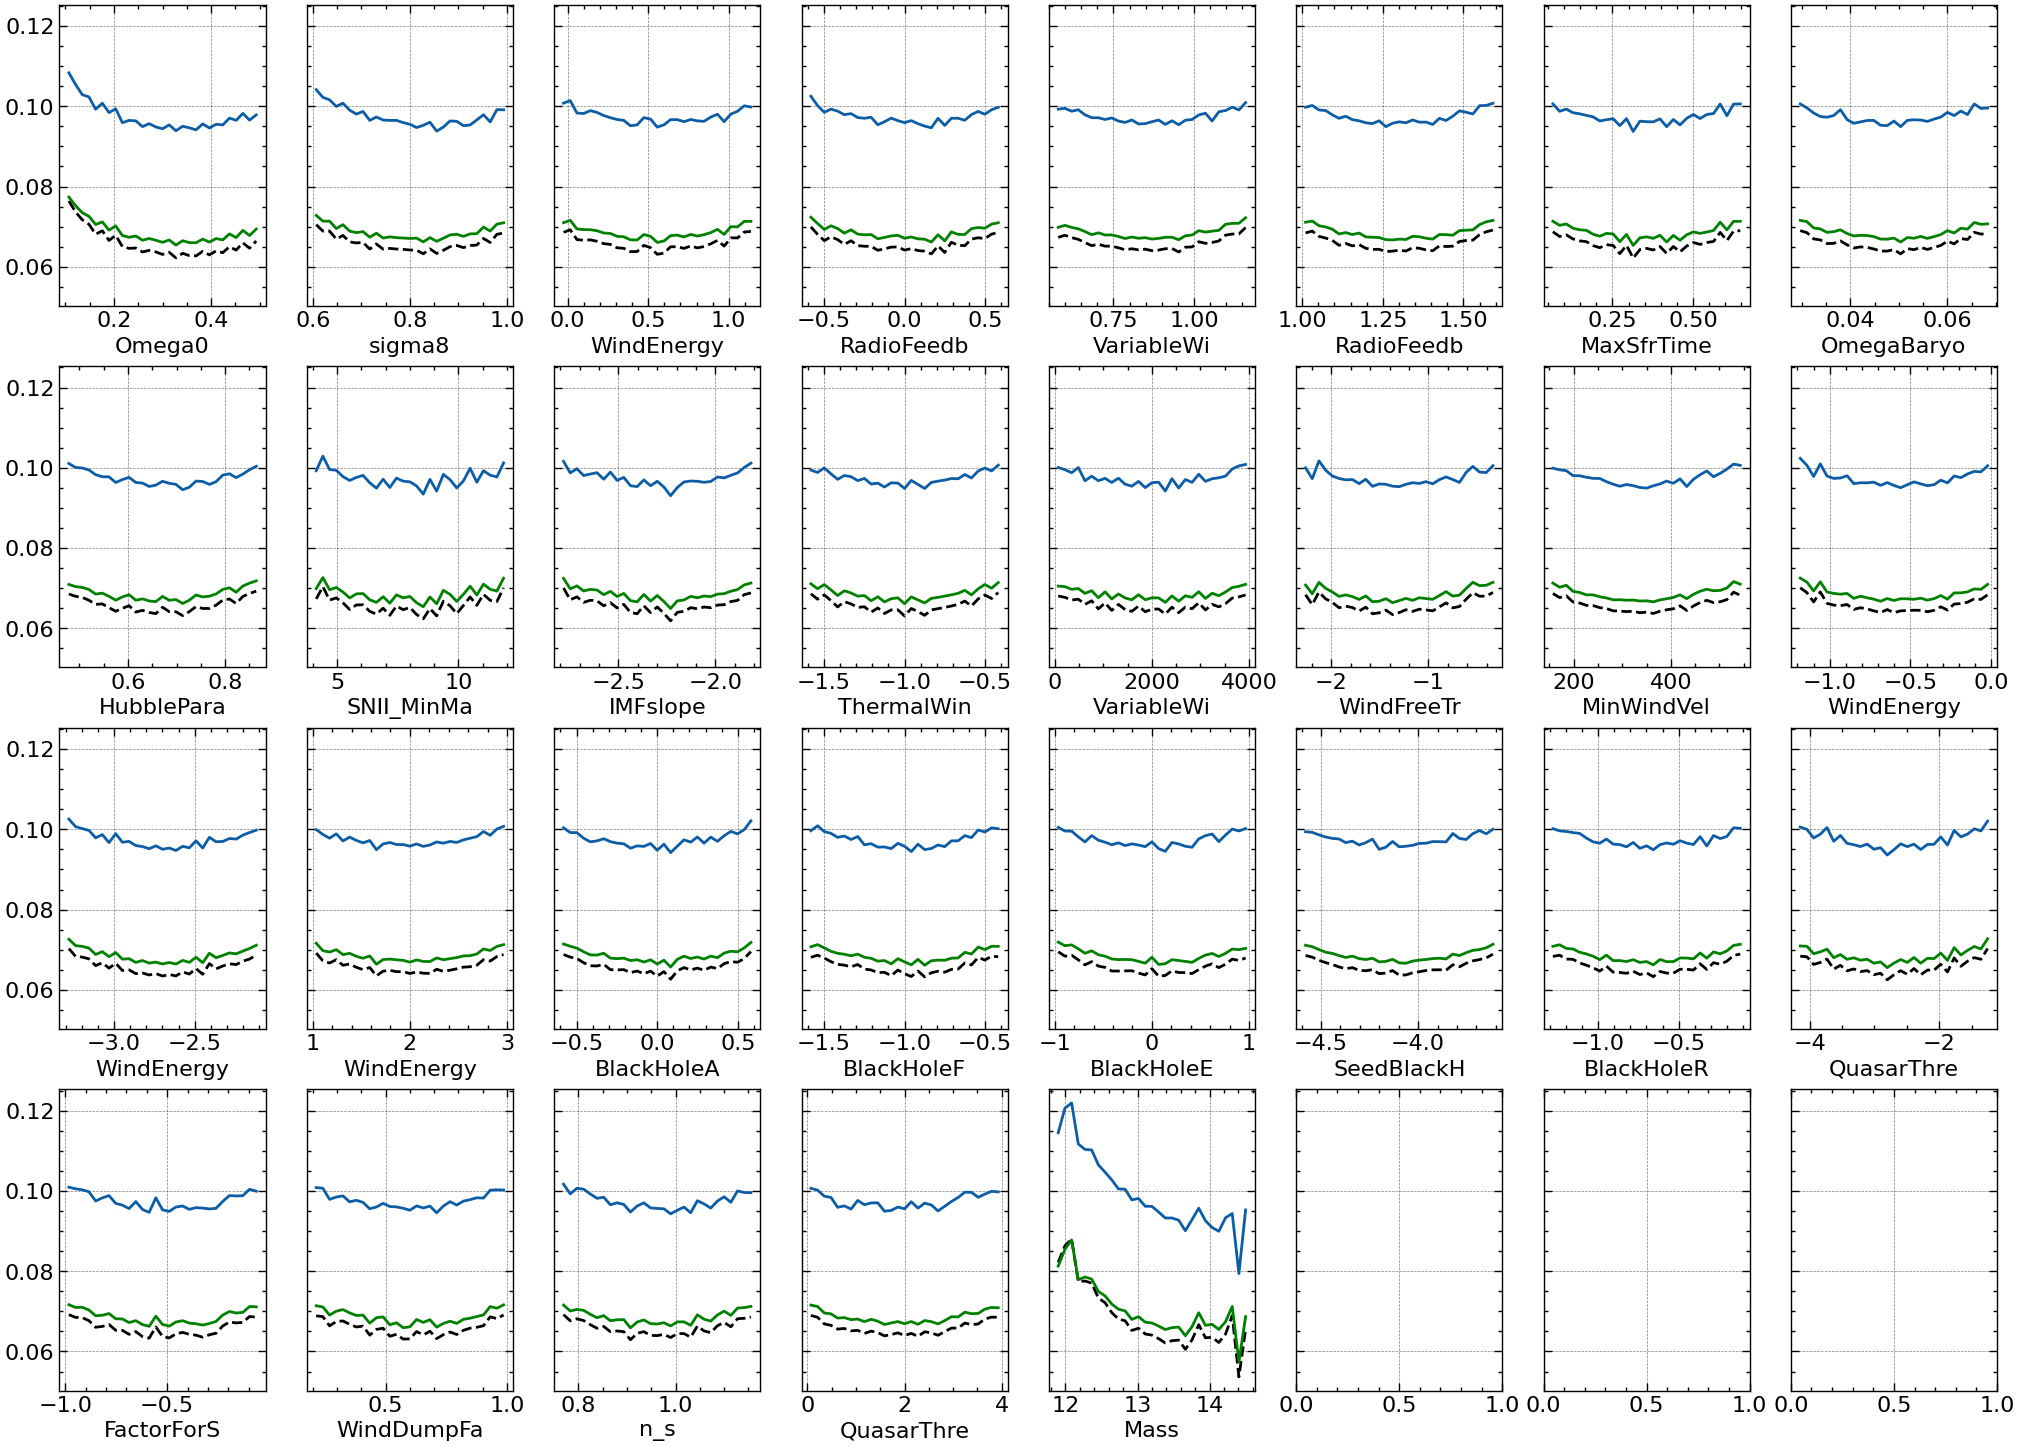

In [158]:
fig, axs = plt.subplots(ncols=8, nrows=4, figsize=(25, 18), sharey=True)
for i in range(32):
    if i<29:
        if i<28:
            if bool(param_info['LogFlag'][i]) == True:
                p = np.log10(test_params[:, i])
            else:
                p = test_params[:, i]
            bins = np.linspace(p.min(), p.max(), 30)
            line = binned_statistic(p, np.diag(VCP)**(0.5), bins=bins)[0]
            plot_bins = bins[1:] - 1/2 * np.median(np.diff(bins))
            axs[i//8, i%8].plot(plot_bins, line, '-')
            
            line = binned_statistic(p, np.diag(VCP_pred)**(0.5), bins=bins)[0]
            plot_bins = bins[1:] - 1/2 * np.median(np.diff(bins))
            axs[i//8, i%8].plot(plot_bins, line, 'k--', label='Stage1 Pred')
            
            line = binned_statistic(p, np.diag(VCP2)**(0.5), bins=bins)[0]
            plot_bins = bins[1:] - 1/2 * np.median(np.diff(bins))
            axs[i//8, i%8].plot(plot_bins, line, 'g-', label='Stage2')
            
            # axs[i//8, i%8].set_yticks([])
            axs[i//8, i%8].set_xlabel(param_info.loc[i, 'ParamName'][:10])
        

        else:
            p = Mass
            bins = np.linspace(p.min(), p.max(), 30)
            line = binned_statistic(p, np.diag(VCP)**(0.5), bins=bins)[0]
            plot_bins = bins[1:] - 1/2 * np.median(np.diff(bins))
            axs[i//8, i%8].plot(plot_bins, line, '-')
            
            line = binned_statistic(p, np.diag(VCP_pred)**(0.5), bins=bins)[0]
            plot_bins = bins[1:] - 1/2 * np.median(np.diff(bins))
            axs[i//8, i%8].plot(plot_bins, line, 'k--', label='Stage1 Pred')
            
            line = binned_statistic(p, np.diag(VCP2)**(0.5), bins=bins)[0]
            plot_bins = bins[1:] - 1/2 * np.median(np.diff(bins))
            axs[i//8, i%8].plot(plot_bins, line, 'g-', label='Stage2')
            # axs[i//8, i%8].set_yticks([])
            axs[i//8, i%8].set_xlabel('Mass')
        # axs[i//8, i%8].set_yticks([])


# Accounting for missing thetas

In [662]:
N = np.load('Data/Sims1.npz')['N']
Nr = np.load('Data/Sims1rusty.npz')['N']

In [664]:
to_sim = theta.copy()
to_sim = np.delete(to_sim, np.concatenate((N, Nr)), axis=0)
to_sim =(to_sim - np.array(theta.min(axis=0)[:]))/(np.array(theta.min(axis=0)[:] - theta.max(axis=0)[:])) + 1

simd_data, _ = emuCP.predict(to_sim)


to_surr = theta_R.copy()
to_surr = np.delete(to_surr, np.concatenate((N, Nr)), axis=0)
to_surr = (to_surr - np.array(theta.min(axis=0)[:]))/(np.array(theta.min(axis=0)[:] - theta.max(axis=0)[:])) + 1
surrd_data, _ = emuCP.predict(to_surr)

    

In [665]:
emuCP.Simulations.update(to_sim, simd_data)
emuCP.Surrogates.update(to_surr, surrd_data)

In [669]:
emuCP.Surrogates.parameters.shape

(128, 29)

In [666]:
# Train the emulator
emuCP.train(params,learning_rate=1e-3, max_iterations=5000)

# now emulate! 
pred_mean, pred_var = emuCP.predict(test_theta)

TypeError: Using a non-tuple sequence for multidimensional indexing is not allowed; use `arr[tuple(seq)]` instead of `arr[seq]`. See https://github.com/google/jax/issues/4564 for more information.

# Active learning approach

In [443]:
import time

In [444]:
def chi2(model, data, cov):
    """
    Calculates the chi2 of the emulator.

    Parameters
    ----------
    model : array
        Model values.
    data : array
        Data values.
    covariance : array
        Covariance of the data.

    Returns
    -------
    chi2 : float
        Chi2 of the emulator.
    """
    return np.sum((data - model)**2/ np.sqrt(np.diag(cov)))



In [456]:
params = {"log_scaleV"   :5*np.ones(emuCP.param_dimensions),
        "log_scaleX" :5*np.ones(emuCP.param_dimensions),
        "log_scaleW" : 5*np.ones(emuCP.param_dimensions),
        "log_scaleM" :5*np.ones(emuCP.param_dimensions),
        "log_ampV"   :0.5*np.ones(emuCP.param_dimensions),
        "log_ampW"   :0.3*np.ones(emuCP.param_dimensions),
        "log_ampX"   :-1.*np.ones(emuCP.param_dimensions),                
        "log_deltaP" :0*np.ones(emuCP.param_dimensions),
        "log_jitterV":-2.0,
        "log_jitterW":-2.0,
        "log_mean"   :-1.0}
# Now we can iteratively do this:
pred_tests = []
pred_vars = []

# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = X; sims.quantities=data
surrs.parameters = X_R; surrs.quantities=surrogate_data

# Generate an active learning model
emu = CARPoolEmulator.ActiveLearning(sims, surrs, theta, 
                                        np.zeros(29), 
                                        np.ones(29))

# Initialize the training
best_params = emu.train(params, learning_rate=1e-3, max_iterations=1000)
start = time.time()
# Run an active learning step to find the next state (Ngrid is for 2**N)
next_thetas, next_surrogates = emu.active_learning_step(num_new=128, Ngrid=9)   
print('Time : ', time.time()-start)

    # next_data, next_noise = generate_model(next_thetas, 
    #                                    uncorr_gp, 
    #                                    Y_mean, 
    #                                    seed=i*123 + 123, sigma=sigma)
    # next_surrogate_data   = generatesurr_model(next_surrogates, uncorr_gp, Y_mean, next_noise)

    # emu.Simulations.update(next_thetas, next_data)
    # emu.Surrogates.update(next_surrogates, next_surrogate_data)

    # best_params = emu.train(params, learning_rate=1e-3, max_iterations=500)
    
    # pred_test, pred_var = emu.predict(multitesttheta)
    # pred_tests.append(pred_test)
    # pred_vars.append(pred_var)
    # print("Time: %f, Pred Var:%f, chi2:%f" % (time.time() - start, 
    #       round(np.sum(np.diag(pred_var)), 3), 

    #       round(chi2(model, pred_test, pred_var), 3)))
# import pickle
# outfile = open('emu_1p_2', 'wb')
# pickle.dump(emu, outfile)
# outfile.close()

Time :  3995.7331762313843


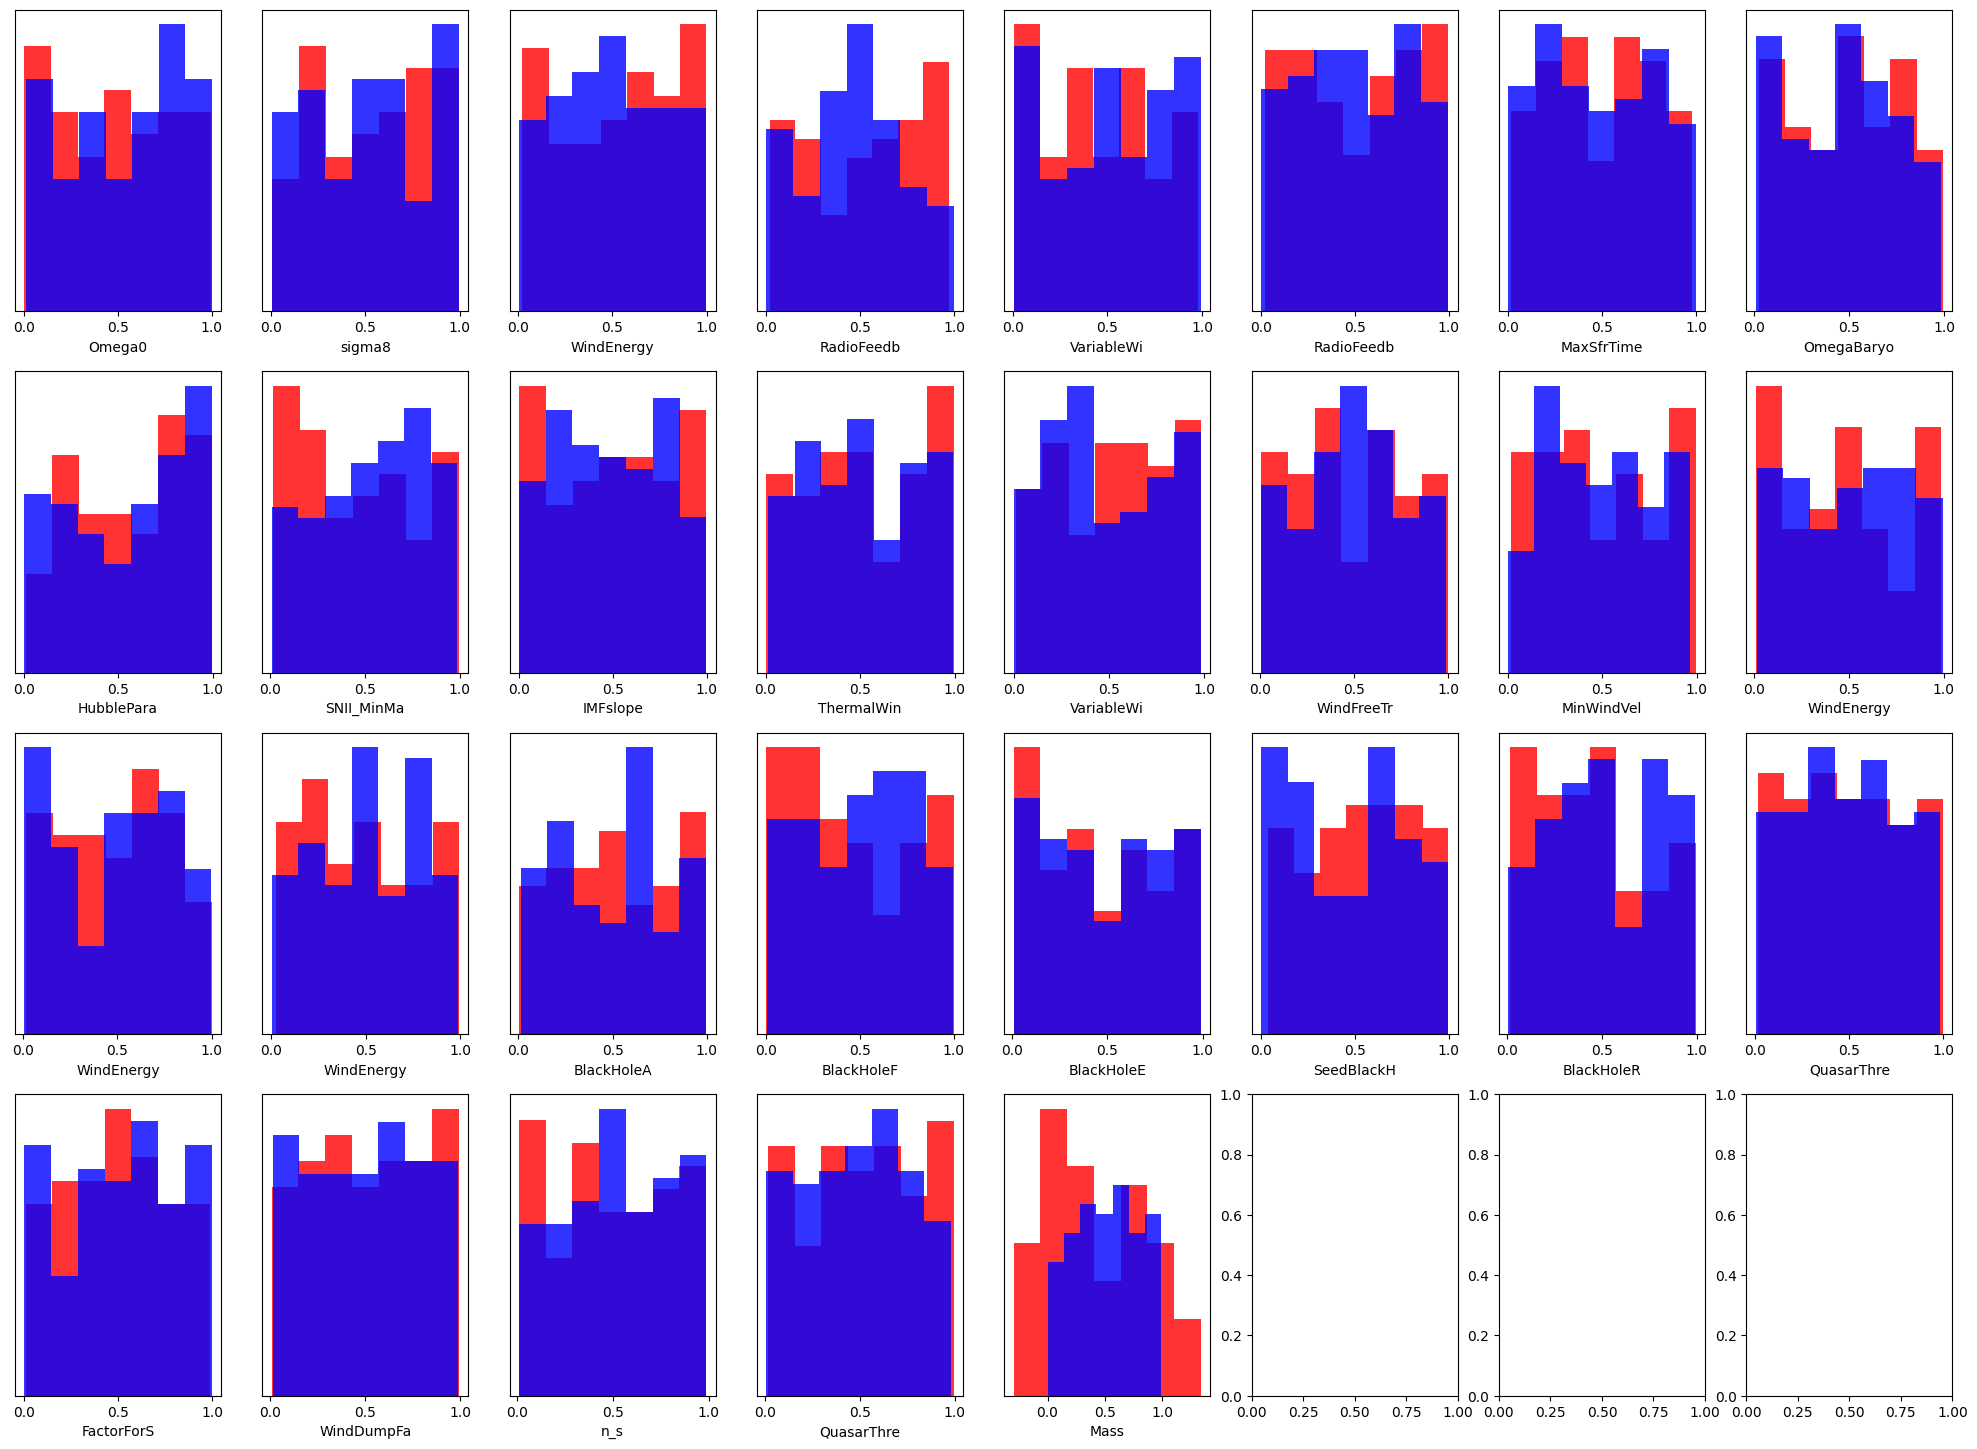

In [462]:
fig, axs = plt.subplots(ncols=8, nrows=4, figsize=(25, 18))
for i in range(32):
    if i<29:
        if i<28:
            axs[i//8, i%8].hist(X[:, i], color='r', alpha=0.8, bins=7)

            axs[i//8, i%8].hist(next_thetas[:, i], color='b', alpha=0.8, bins=7)
            axs[i//8, i%8].set_yticks([])
            axs[i//8, i%8].set_xlabel(df.loc[i, 'ParamName'][:10])

        else:
            axs[i//8, i%8].hist(X[:, i], color='r', alpha=0.8, bins=7)
            axs[i//8, i%8].hist(next_thetas[:, i], color='b', alpha=0.8, bins=7)
            axs[i//8, i%8].set_yticks([])
            axs[i//8, i%8].set_xlabel('Mass')
        axs[i//8, i%8].set_yticks([])


In [ ]:
 - np.array(param_df.min(axis=0)[:-1]))/(np.array(param_df.min(axis=0)[:-1] - param_df.max(axis=0)[:-1])) + 1

In [470]:
next_thetas_real = (next_thetas -1 ) * (np.array(param_df.min(axis=0)[:-1] - param_df.max(axis=0)[:-1])) + np.array(param_df.min(axis=0)[:-1])
next_surrogates_real = (next_surrogates -1 ) * (np.array(param_df.min(axis=0)[:-1] - param_df.max(axis=0)[:-1])) + np.array(param_df.min(axis=0)[:-1])

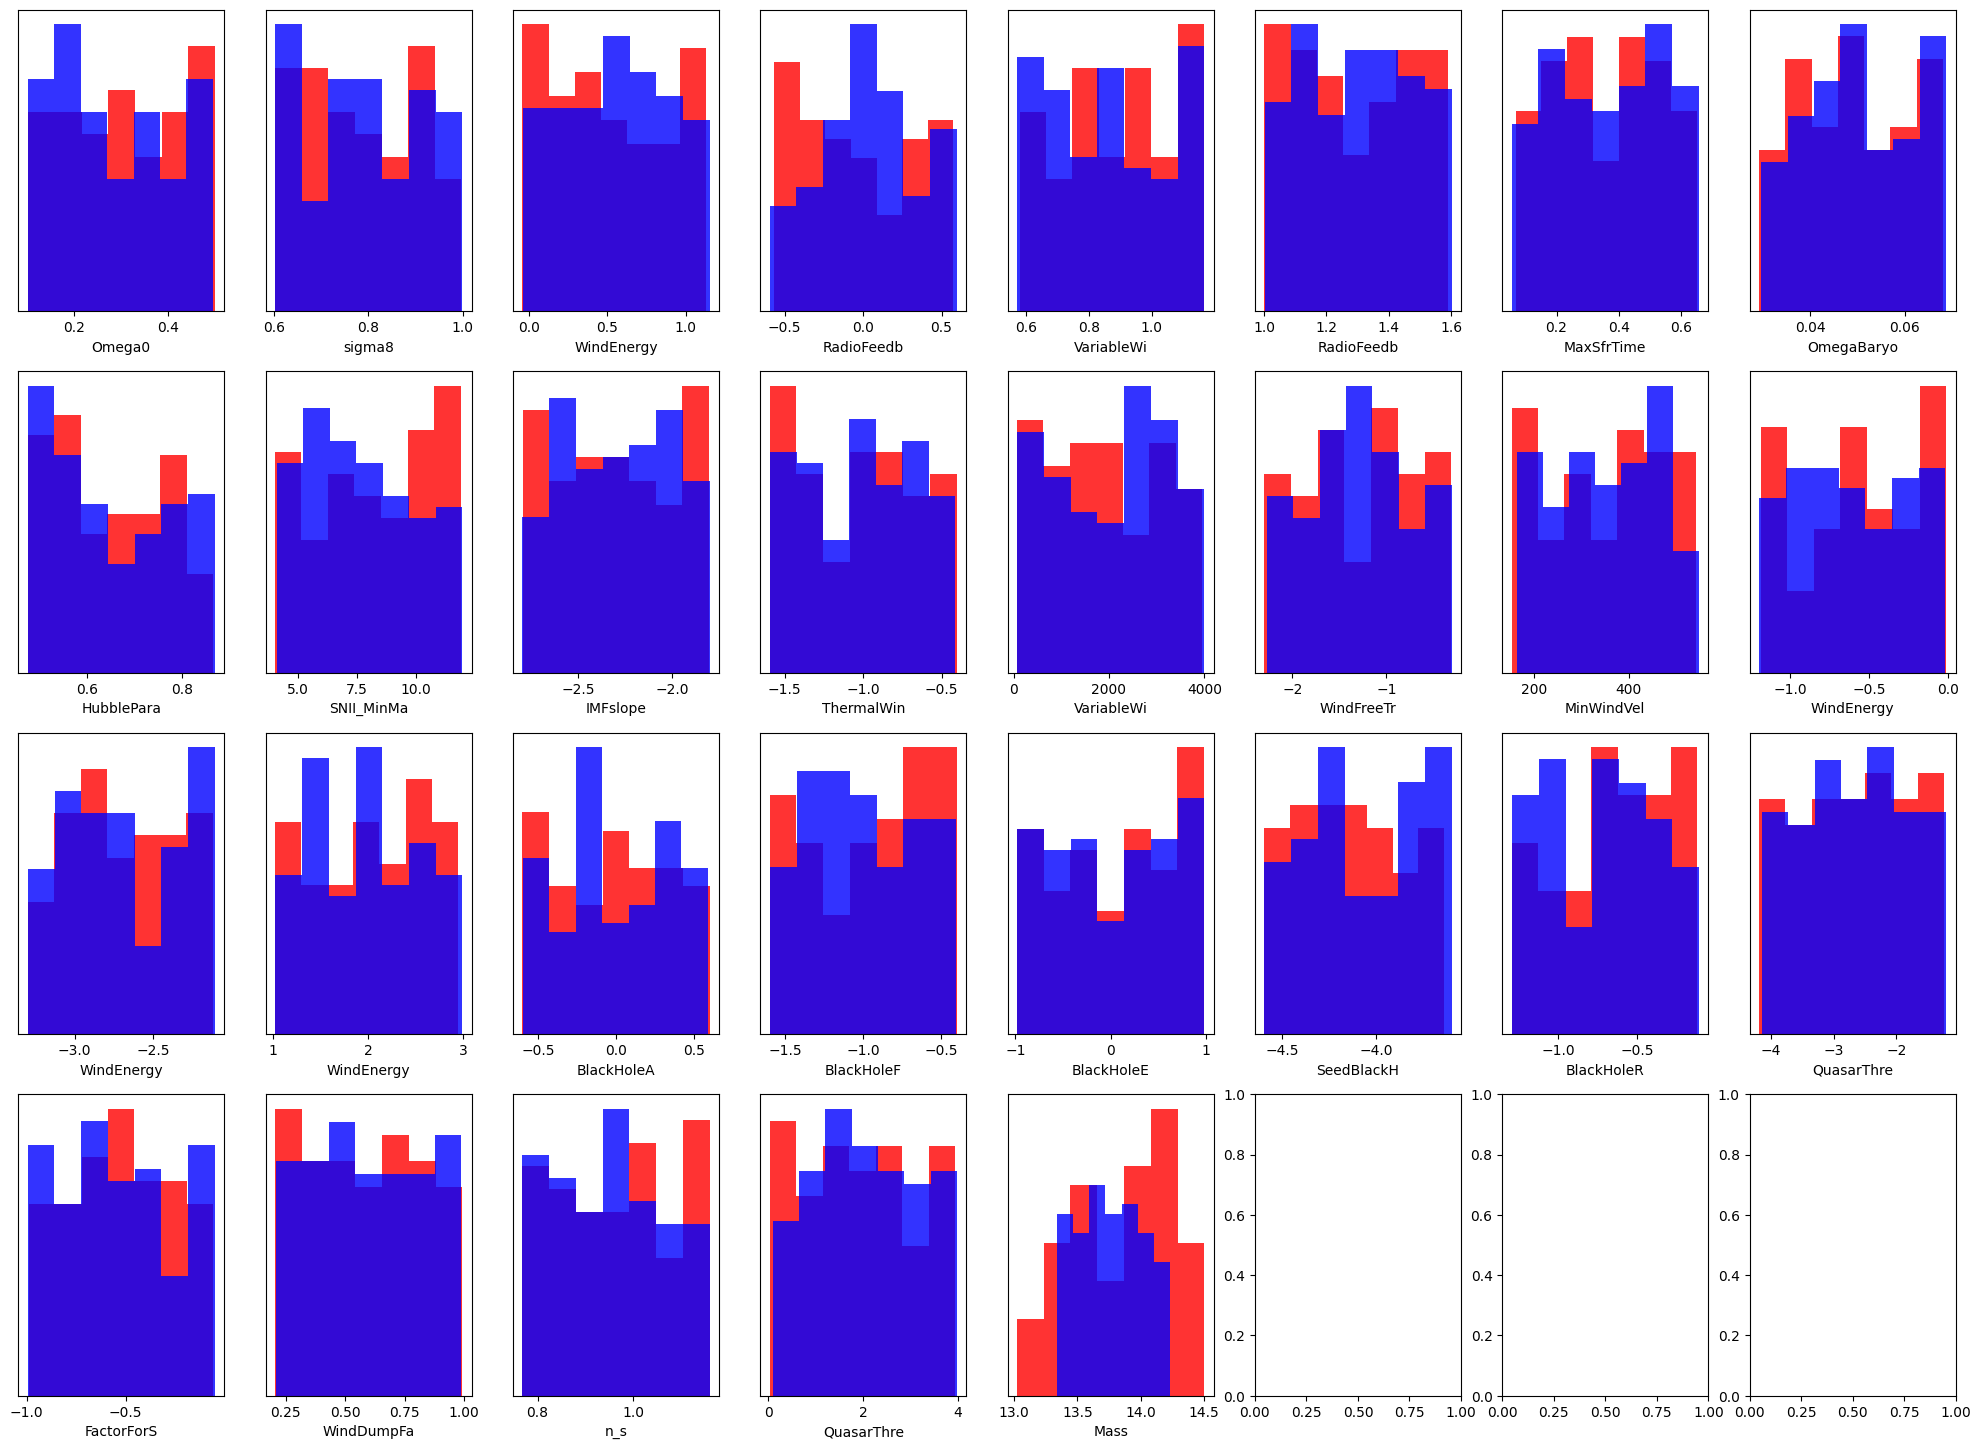

In [471]:
fig, axs = plt.subplots(ncols=8, nrows=4, figsize=(25, 18))
for i in range(32):
    if i<29:
        if i<28:
            axs[i//8, i%8].hist(theta[:, i], color='r', alpha=0.8, bins=7)

            axs[i//8, i%8].hist(next_thetas_real[:, i], color='b', alpha=0.8, bins=7)
            axs[i//8, i%8].set_yticks([])
            axs[i//8, i%8].set_xlabel(df.loc[i, 'ParamName'][:10])

        else:
            axs[i//8, i%8].hist(theta[:, i], color='r', alpha=0.8, bins=7)
            axs[i//8, i%8].hist(next_thetas_real[:, i], color='b', alpha=0.8, bins=7)
            axs[i//8, i%8].set_yticks([])
            axs[i//8, i%8].set_xlabel('Mass')
        axs[i//8, i%8].set_yticks([])


In [306]:
# import pickle
# outfile = open('emu_1p_2', 'wb')
# pickle.dump(emu, outfile)
# outfile.close()

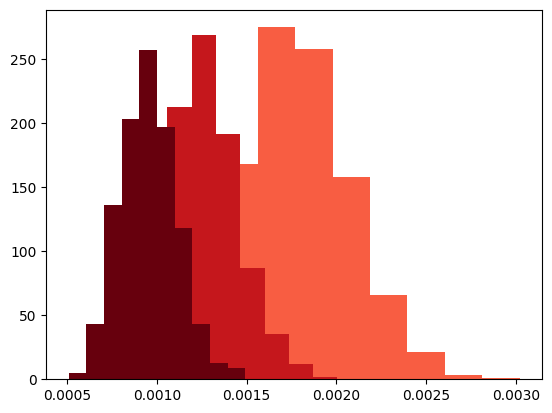

In [307]:
cs = plt.cm.Reds(np.linspace(0.3, 1, len(pred_tests)))
M= uncorr_gp.predict(Y_mean, multitesttheta)
for i in range(1, 4):
    var = np.diag(pred_vars[i]).flatten()
    plt.hist(var, color=cs[i], alpha=1, bins=10, log=False)
    

-5.243700572333901
-11.623004900543886
-7.623443999730769


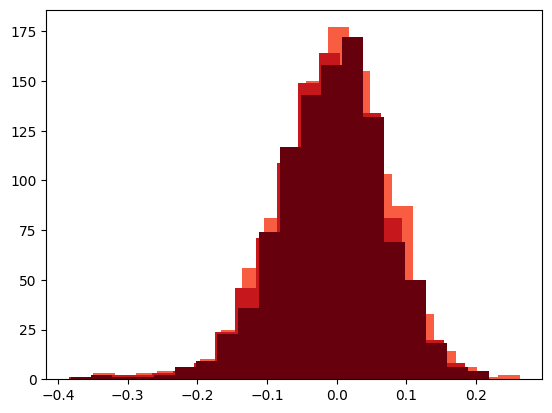

In [308]:
cs = plt.cm.Reds(np.linspace(0.3, 1, len(pred_tests)))
M= uncorr_gp.predict(Y_mean, multitesttheta)
for i in range(1, 4):
    var = (M - pred_tests[i])#/np.diag(pred_vars[i])
    plt.hist(var, color=cs[i], alpha=1, bins=20)
    print(np.sum(var))

# Looking at pretrained network

In [19]:
import pickle

In [20]:
params = {"log_scaleV"   :7*np.ones(emuCP.param_dimensions),
        "log_scaleX" :7*np.ones(emuCP.param_dimensions),
        "log_scaleW" : 7*np.ones(emuCP.param_dimensions),
        "log_scaleM" :7*np.ones(emuCP.param_dimensions),
        "log_ampV"   :0.5*np.ones(emuCP.param_dimensions),
        "log_ampW"   :0.3*np.ones(emuCP.param_dimensions),
        "log_ampX"   :-1.*np.ones(emuCP.param_dimensions),                
        "log_deltaP" :0*np.ones(emuCP.param_dimensions),
        "log_jitterV":-2.0,
        "log_jitterW":-2.0,
        "log_mean"   :-1.0}

In [188]:
file = open('emu_1p_2', 'rb')
emu = pickle.load(file)
file.close()

First lets look at if this worked at all. We need to rerun the training but thats ok

In [22]:
M, V = emu.predict(multitesttheta)

In [23]:
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = emu.Simulations.parameters[:128]
sims.quantities=emu.Simulations.quantities[:128]
surrs.parameters = emu.Surrogates.parameters[:128]
surrs.quantities=emu.Surrogates.quantities[:128]

# Generate an emulator and train
emu0 = CARPoolEmulator.Emulator(sims, surrs)
best_params0 = emu0.train(params, learning_rate=1e-3, max_iterations=500)

In [24]:
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = emu.Simulations.parameters[:256]
sims.quantities=emu.Simulations.quantities[:256]
surrs.parameters = emu.Surrogates.parameters[:256]
surrs.quantities=emu.Surrogates.quantities[:256]

# Generate an emulator and train
emu1 = CARPoolEmulator.Emulator(sims, surrs)
best_params1 = emu1.train(params, learning_rate=1e-3, max_iterations=500)

In [25]:
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = emu.Simulations.parameters[:384]
sims.quantities=emu.Simulations.quantities[:384]
surrs.parameters = emu.Surrogates.parameters[:384]
surrs.quantities=emu.Surrogates.quantities[:384]

# Generate an emulator and train
emu2 = CARPoolEmulator.Emulator(sims, surrs)
best_params2 = emu2.train(params, learning_rate=1e-3, max_iterations=500)

In [26]:
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = emu.Simulations.parameters
sims.quantities=emu.Simulations.quantities
surrs.parameters = emu.Surrogates.parameters
surrs.quantities=emu.Surrogates.quantities

# Generate an emulator and train
emu3 = CARPoolEmulator.Emulator(sims, surrs)
best_params3 = emu3.train(params, learning_rate=1e-3, max_iterations=500)

## Testing on the 1P model, how well do we do

In [27]:
emus = [emu0, emu1, emu2, emu3]
Ms, Vs  = [], []
for em in emus:
    # Predict the 1P set
    M, V = em.predict(test_theta)
    Ms.append(M)
    Vs.append(V)

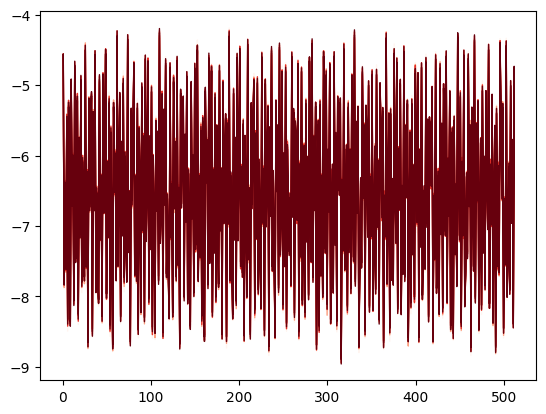

In [32]:
cs = plt.cm.Reds(np.linspace(0, 1, 4))
for M, V, c in zip(Ms, Vs, cs):
    plt.fill_between(np.arange(len(M)), M -np.sqrt(np.diag(V)), M+np.sqrt(np.diag(V)), color=c)

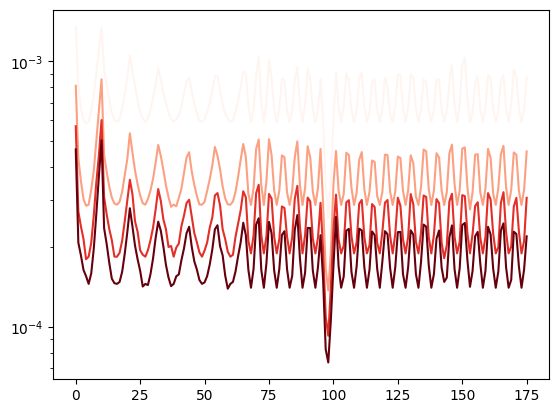

In [64]:
for v, c in zip(Vs, cs):
    plt.semilogy(np.diag(v), c=c)

Text(0, 0.5, 'Variance reduction [$\\sigma_0/\\sigma_n$]')

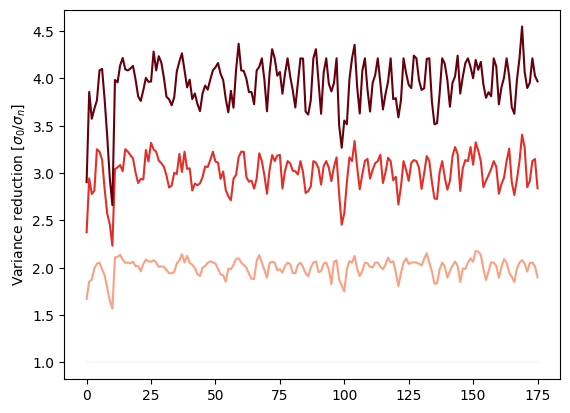

In [65]:
for v, c in zip(Vs, cs):
    plt.plot(np.diag(Vs[0]) / np.diag(v), c=c)
plt.ylabel('Variance reduction [$\sigma_0/\sigma_n$]')

It looks like we get a factor of ~3.5 better variance reduction here. Can we compare this to just a regular gaussian process?

In [113]:
params = {"log_scaleV"   :3*np.ones(emuCP.param_dimensions),
        "log_scaleX" :0*np.ones(emuCP.param_dimensions),
        "log_scaleW" : 3*np.ones(emuCP.param_dimensions),
        "log_scaleM" :0*np.ones(emuCP.param_dimensions),
        "log_ampV"   :0.5*np.ones(emuCP.param_dimensions),
        "log_ampW"   :0.3*np.ones(emuCP.param_dimensions),
        "log_ampX"   :0.*np.ones(emuCP.param_dimensions),                
        "log_deltaP" :0*np.ones(emuCP.param_dimensions),
        "log_jitterV":-2.0,
        "log_jitterW":-2.0,
        "log_mean"   :-1.0}
theta_reg = generate_theta(param_df, N=10, d=29, seed=31)
data_reg, _  = generate_model(theta_reg, uncorr_gp=uncorr_gp, Y_mean=Y_mean, seed=192, sigma=sigma )
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = theta_reg[:512]
sims.quantities  =  data_reg[:512]
surrs.parameters = theta_reg[512:]
surrs.quantities=data_reg[512:]

# Generate an emulator and train
emu_reg = CARPoolEmulator.Emulator(sims, surrs)
best_params_reg = emu_reg.train(params, learning_rate=1e-3, max_iterations=50)

In [114]:
Mreg, Vreg = emu_reg.predict(test_theta)
MCP, VCP = emuCP.predict(test_theta)

ValueError: operands could not be broadcast together with shapes (512,) (176,) 

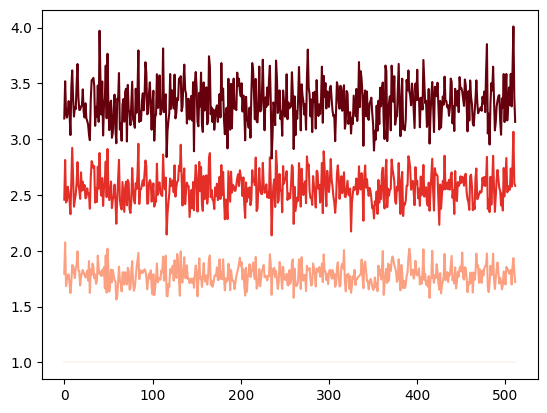

In [115]:
for v, c in zip(Vs, cs):
    plt.plot(np.diag(Vs[0]) / np.diag(v), c=c)

plt.plot( np.diag(Vs[0]) /np.diag(Vreg), c='k', ls=':')
plt.plot( np.diag(Vs[0]) /np.diag(VCP), c='k', ls='--')

plt.ylabel('Variance reduction [$\sigma_0/\sigma_n$]')

# Now more thetas?

Text(0, 0.5, 'N')

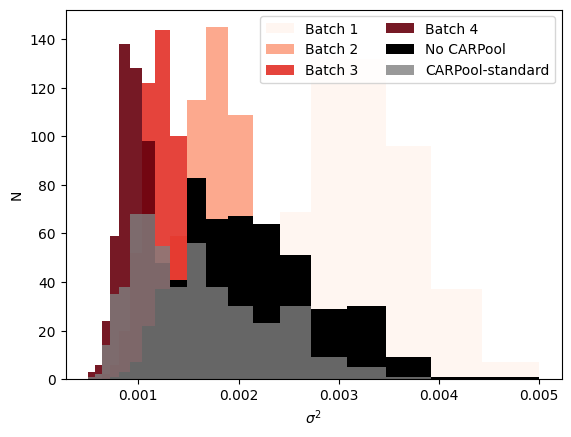

In [116]:
emus = [emu0, emu1, emu2, emu3]
Ms, Vs  = [], []
for em in emus:
    # Predict the 1P set
    M, V = em.predict(multitesttheta)
    Ms.append(M)
    Vs.append(V)
Mreg, Vreg = emu_reg.predict(multitesttheta)
MCP, VCP = emuCP.predict(multitesttheta)

plt.figure()
for v, c, i in zip(Vs, cs, np.arange(4)):
    plt.hist(np.diag(v), color=c, alpha=0.9, bins=np.logspace(np.log10(0.0005), np.log10(0.005), 20), label='Batch %i'%(i+1))
_ = plt.hist(np.diag(Vreg), color='k', alpha=1, bins=np.logspace(np.log10(0.0005), np.log10(0.005), 20), label='No CARPool')
_ = plt.hist(np.diag(VCP), color='grey', alpha=0.8, bins=np.logspace(np.log10(0.0005), np.log10(0.005), 20), label='CARPool-standard')


plt.legend(ncols=2)

plt.xlabel('$\sigma^2$')
plt.ylabel('N')

# Predicting on a different dataset?

In [118]:
data = np.load('Data/first_1_SB28.npz')
S_mean = np.log10(data['S'][usable_data, 0])
uncorr_gp = train_gp(29, build_gp_uncorr, X, S_mean)

In [162]:
sigma = np.sqrt(uncorr_gp.noise.diag[0])

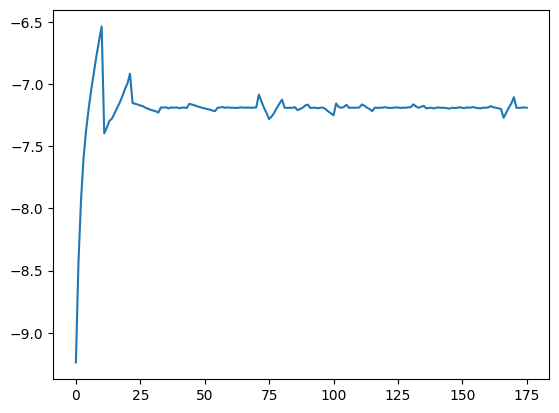

In [163]:
plt.plot(uncorr_gp.predict(S_mean,test_theta ))

In [189]:
params = {"log_scaleV"   :7*np.ones(emuCP.param_dimensions),
        "log_scaleX" :7*np.ones(emuCP.param_dimensions),
        "log_scaleW" : 7*np.ones(emuCP.param_dimensions),
        "log_scaleM" :7*np.ones(emuCP.param_dimensions),
        "log_ampV"   :0.5*np.ones(emuCP.param_dimensions),
        "log_ampW"   :0.3*np.ones(emuCP.param_dimensions),
        "log_ampX"   :-1.*np.ones(emuCP.param_dimensions),                
        "log_deltaP" :0*np.ones(emuCP.param_dimensions),
        "log_jitterV":-2.0,
        "log_jitterW":-2.0,
        "log_mean"   :-1.0}

In [184]:
sigma

0.20320948979121678

In [165]:
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = emu.Simulations.parameters[:128]
data, intrinsic_noise  = generate_model(emu.Simulations.parameters[:128], uncorr_gp, S_mean, sigma=sigma)
sims.quantities = data
surrs.parameters = emu.Surrogates.parameters[:128]
surrs.quantities = uncorr_gp.predict(S_mean, surrs.parameters[:128]) + intrinsic_noise

# Generate an emulator and train
emuS0 = CARPoolEmulator.Emulator(sims, surrs)
best_paramsS0 = emuS0.train(params, learning_rate=1e-3, max_iterations=500)

In [166]:
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = emu.Simulations.parameters[:256]
data, intrinsic_noise  = generate_model(emu.Simulations.parameters[:256], uncorr_gp, S_mean, sigma=sigma)
sims.quantities = data
surrs.parameters = emu.Surrogates.parameters[:256]
surrs.quantities = uncorr_gp.predict(S_mean, surrs.parameters[:256]) + intrinsic_noise

# Generate an emulator and train
emuS1 = CARPoolEmulator.Emulator(sims, surrs)
best_paramsS1 = emuS1.train(params, learning_rate=1e-3, max_iterations=500)

In [167]:
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = emu.Simulations.parameters[:384]
data, intrinsic_noise  = generate_model(emu.Simulations.parameters[:384], uncorr_gp, S_mean, sigma=sigma)
sims.quantities = data
surrs.parameters = emu.Surrogates.parameters[:384]
surrs.quantities = uncorr_gp.predict(S_mean, surrs.parameters[:384]) + intrinsic_noise

# Generate an emulator and train
emuS2 = CARPoolEmulator.Emulator(sims, surrs)
best_paramsS2 = emuS2.train(params, learning_rate=1e-3, max_iterations=500)

In [201]:
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = emu.Simulations.parameters
data, intrinsic_noise  = generate_model(emu.Simulations.parameters, uncorr_gp, S_mean, sigma=sigma)
sims.quantities = data
surrs.parameters = emu.Surrogates.parameters
surrs.quantities = uncorr_gp.predict(S_mean, surrs.parameters) + intrinsic_noise

# Generate an emulator and train
emuS3 = CARPoolEmulator.Emulator(sims, surrs)
best_paramsS3 = emuS3.train(params, learning_rate=1e-3, max_iterations=200)

In [169]:
params = {"log_scaleV"   :7*np.ones(emu.param_dimensions),
        "log_scaleX" :7*np.ones(emu.param_dimensions),
        "log_scaleW" : 7*np.ones(emu.param_dimensions),
        "log_scaleM" :7*np.ones(emu.param_dimensions),
        "log_ampV"   :0.5*np.ones(emu.param_dimensions),
        "log_ampW"   :0.3*np.ones(emu.param_dimensions),
        "log_ampX"   :-1.*np.ones(emu.param_dimensions),                
        "log_deltaP" :0*np.ones(emu.param_dimensions),
        "log_jitterV":-2.0,
        "log_jitterW":-2.0,
        "log_mean"   :-1.0}
theta_reg = generate_theta(param_df, N=10, d=29, seed=31)
data_reg, _  = generate_model(theta_reg, uncorr_gp=uncorr_gp, Y_mean=S_mean, seed=192, sigma=sigma)
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = theta_reg[:512]
sims.quantities  =  data_reg[:512]
surrs.parameters = theta_reg[512:]
surrs.quantities=data_reg[512:]

# Generate an emulator and train
emu_regS = CARPoolEmulator.Emulator(sims, surrs)
best_params_regS = emu_regS.train(params, learning_rate=1e-3, max_iterations=50)

In [147]:
np.sqrt(np.median(uncorr_gp.noise.diag))

0.20320948979121678

In [170]:
params = {"log_scaleV"   :3*np.ones(emu.param_dimensions),
        "log_scaleX" :3*np.ones(emu.param_dimensions),
        "log_scaleW" : 3*np.ones(emu.param_dimensions),
        "log_scaleM" :3*np.ones(emu.param_dimensions),
        "log_ampV"   :0.5*np.ones(emu.param_dimensions),
        "log_ampW"   :0.3*np.ones(emu.param_dimensions),
        "log_ampX"   :-1.*np.ones(emu.param_dimensions),                
        "log_deltaP" :0*np.ones(emu.param_dimensions),
        "log_jitterV":-2.0,
        "log_jitterW":-2.0,
        "log_mean"   :-1.0}
theta = generate_theta(param_df, N=9, seed=1993, d=29)
    
data, intrinsic_noise = generate_model(theta, 
                                       uncorr_gp, 
                                       Y_mean, 
                                       seed=1902, sigma=sigma)

# theta_R, surrogate_data, surrogate_raw = generate_surrogates(
#                                                 theta, 
#                                                 intrinsic_noise, 
#                                                 uncorr_gp,
#                                                 Y_mean, 
#                                                 Groups=50)
theta_R, surrogate_data, surrogate_raw = generate_surrogates(
                                                theta, 
                                                intrinsic_noise, 
                                                param_df,
                                                uncorr_gp,
                                                Y_mean)

sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = theta
sims.quantities  =  data
surrs.parameters = theta_R
surrs.quantities=surrogate_data

# Generate an emulator and train
emuCPS = CARPoolEmulator.Emulator(sims, surrs)
best_params_CPS = emuCPS.train(params, learning_rate=1e-3, max_iterations=50)

In [171]:
file = open('emu_1p_2S', 'rb')
emu_S = pickle.load(file)
file.close()

In [172]:
params = {"log_scaleV"   :7*np.ones(emuCP.param_dimensions),
        "log_scaleX" :7*np.ones(emuCP.param_dimensions),
        "log_scaleW" : 7*np.ones(emuCP.param_dimensions),
        "log_scaleM" :7*np.ones(emuCP.param_dimensions),
        "log_ampV"   :0.5*np.ones(emuCP.param_dimensions),
        "log_ampW"   :0.3*np.ones(emuCP.param_dimensions),
        "log_ampX"   :-1.*np.ones(emuCP.param_dimensions),                
        "log_deltaP" :0*np.ones(emuCP.param_dimensions),
        "log_jitterV":-2.0,
        "log_jitterW":-2.0,
        "log_mean"   :-1.0}
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = emu_S.Simulations.parameters
sims.quantities = emu_S.Simulations.quantities
surrs.parameters = emu_S.Surrogates.parameters
surrs.quantities = emu_S.Surrogates.quantities

# Generate an emulator and train
emu_S = CARPoolEmulator.Emulator(sims, surrs)
best_params_emu_S = emu_S.train(params, learning_rate=1e-3, max_iterations=500)

In [202]:
emus = [emuS0, emuS1, emuS2, emuS3]
Ms, Vs  = [], []
for em in emus:
    # Predict the 1P set
    M, V = em.predict(test_theta)
    Ms.append(M)
    Vs.append(V)

Text(0, 0.5, 'Variance reduction [$\\sigma_0/\\sigma_n$]')

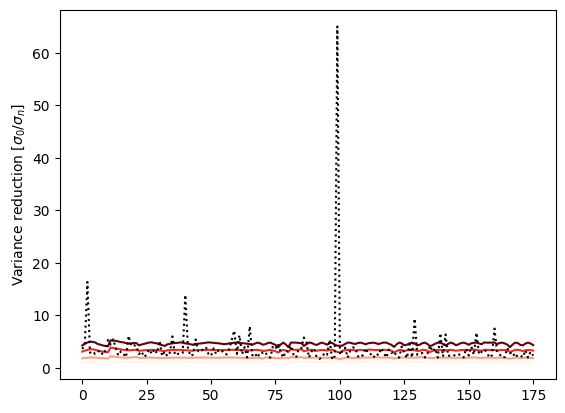

In [177]:
for v, c in zip(Vs, cs):
    plt.plot(np.diag(Vs[0]) / np.diag(v), c=c)
MsS, VsS = emu_regS.predict(test_theta)
plt.plot(np.diag(Vs[0]) / np.abs(np.diag(VsS)), c='k', ls=':')

plt.ylabel('Variance reduction [$\sigma_0/\sigma_n$]')

Text(0.5, 0, '$\\sigma^2_S$')

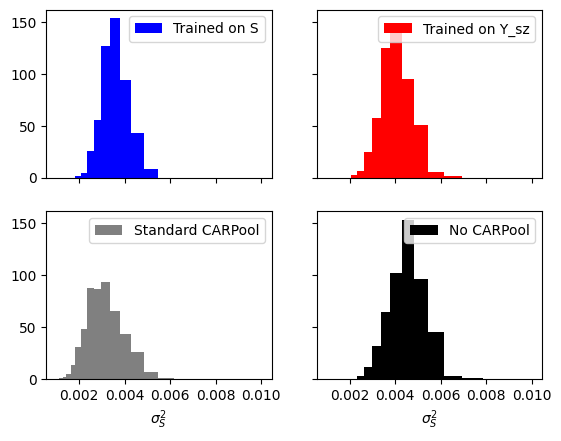

In [220]:
Ms, Vs  = [], []
for em in emus:
    # Predict the 1P set
    M, V = em.predict(multitesttheta)
    Ms.append(M)
    Vs.append(V)
Mreg, Vreg = emu_regS.predict(multitesttheta)
MCP, VCP = emuCPS.predict(multitesttheta)
MS, VS = emu_S.predict(multitesttheta)

fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
# for v, c, i in zip(Vs, cs, np.arange(4)):
_ = axs[0,0].hist(np.abs(np.diag(VS)), color='blue', alpha=1, label='Trained on S',  bins=np.logspace(np.log10(0.001), np.log10(0.01), 20))
_ = axs[0,1].hist(np.abs(np.diag(Vs[-1])), color='red', alpha=1, label='Trained on Y_sz',  bins=np.logspace(np.log10(0.001), np.log10(0.01), 20))
_ =axs[1,0].hist(np.abs(np.diag(VCP)), color='grey', alpha=1, label='Standard CARPool',  bins=np.logspace(np.log10(0.001), np.log10(0.01), 20))
_ = axs[1,1].hist(np.abs(np.diag(Vreg)), color='k', alpha=1, label='No CARPool', bins=np.logspace(np.log10(0.001), np.log10(0.01), 20))

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()


axs[1,0].set_xlabel('$\sigma^2_S$')
axs[1,1].set_xlabel('$\sigma^2_S$')

# plt.ylabel('N')

In [248]:
emu.Simulations.parameters[:128].shape

(128, 29)

In [250]:
df = pd.read_csv('Data/SB28_param_minmax.csv')


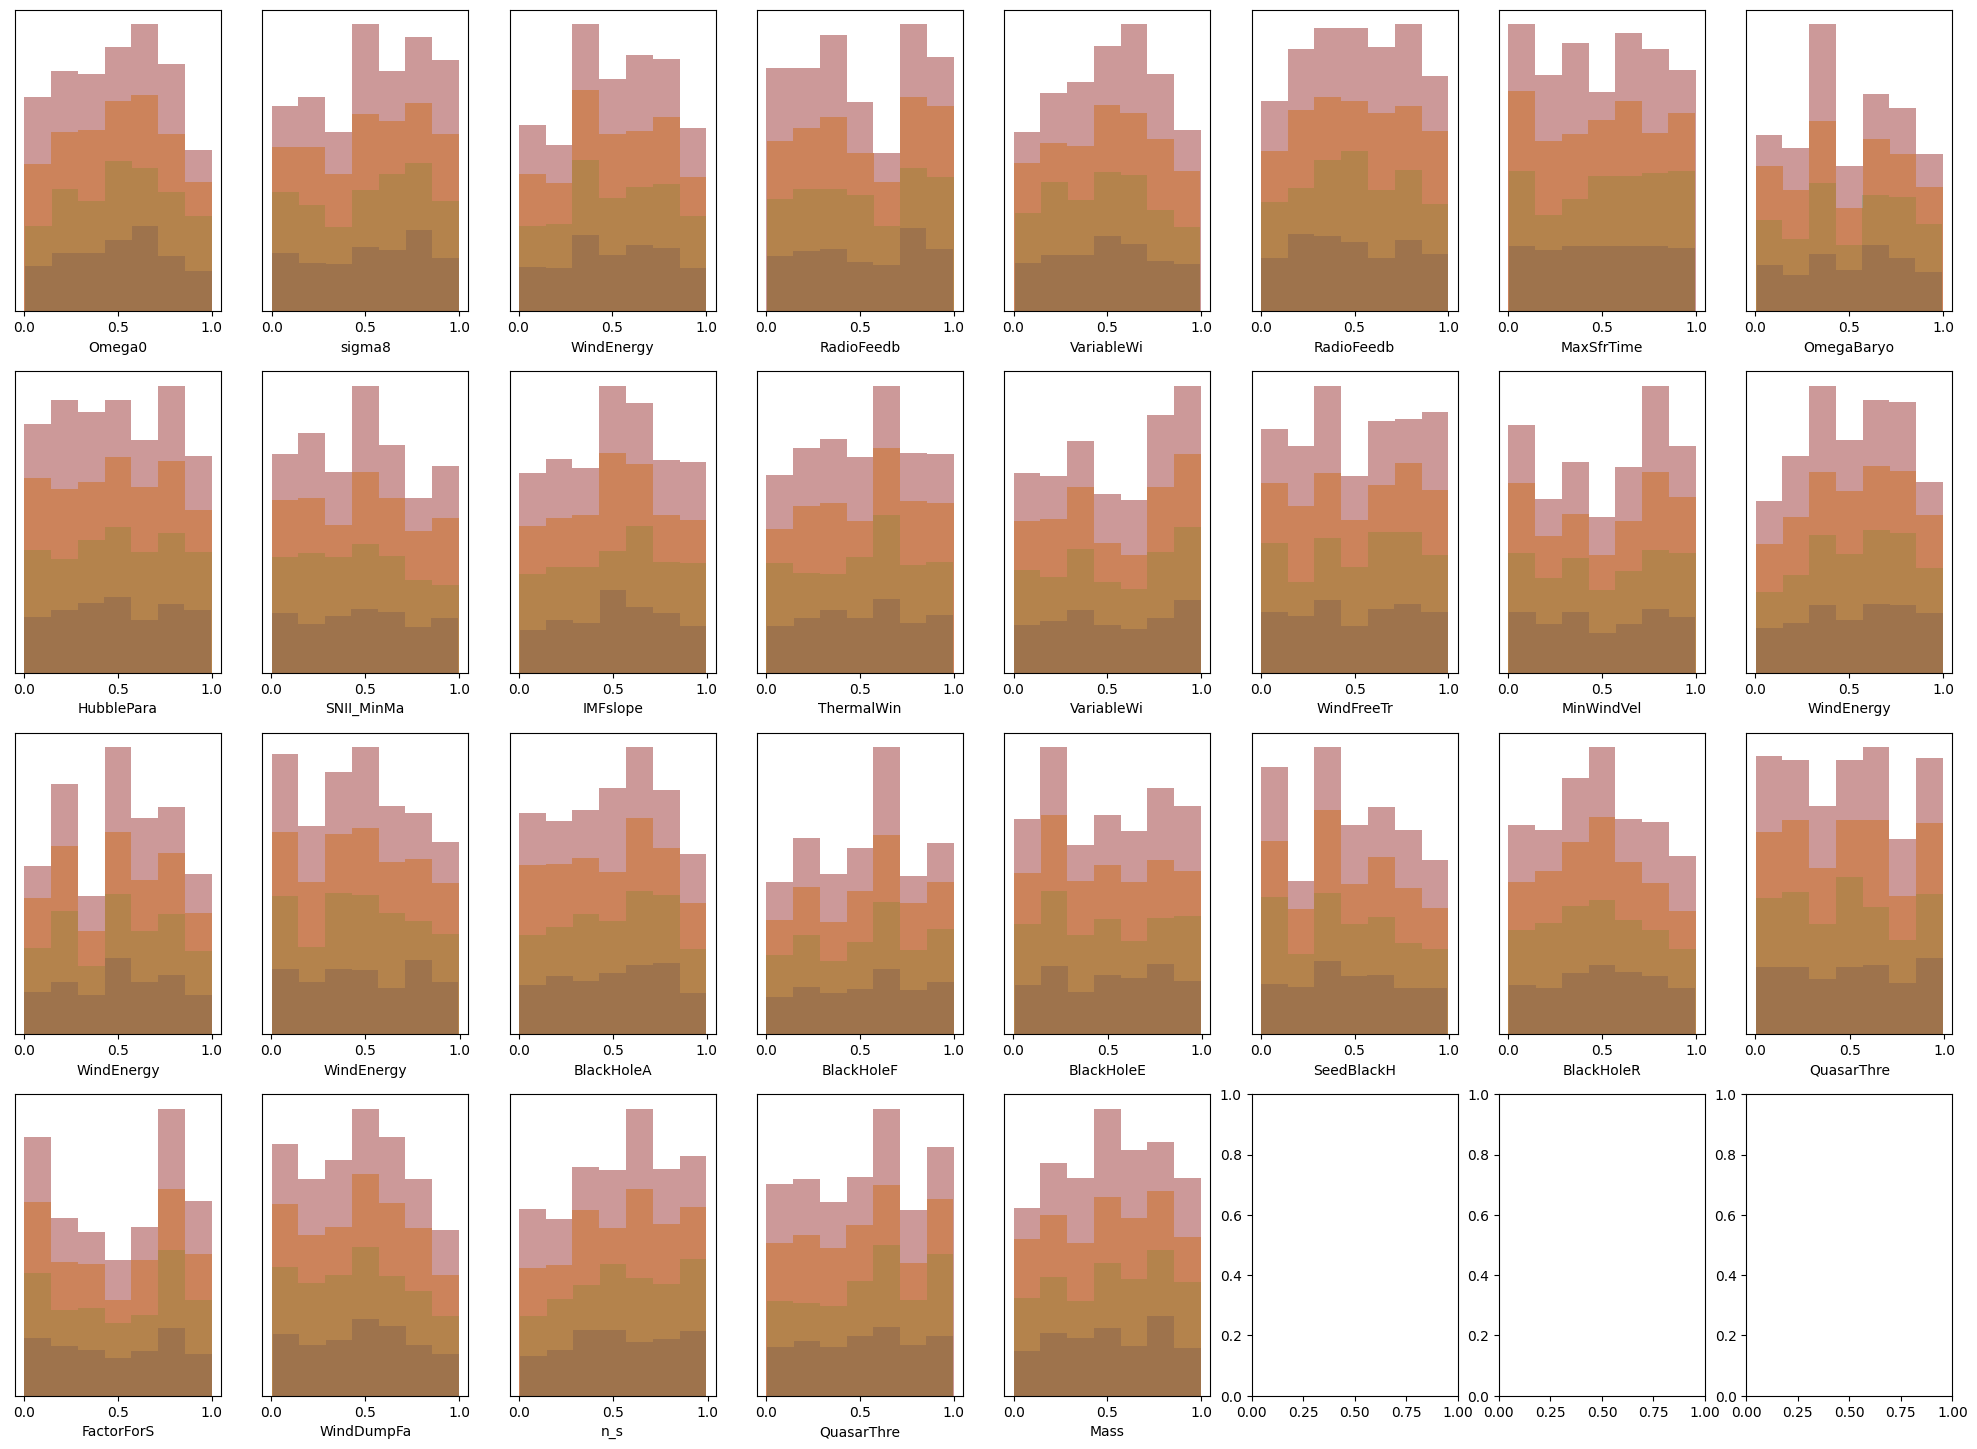

In [277]:
fig, axs = plt.subplots(ncols=8, nrows=4, figsize=(25, 18))
cs = plt.cm.jet(np.linspace(0.2, 1, 4))
for j in range(4):
    theta = np.concatenate((emu.Surrogates.parameters[:128*(j+1)], emu.Simulations.parameters[:128*(j+1)]))

    for i in range(32):
        if i<29:
            if i<28:
                axs[i//8, i%8].hist(theta[:, i], color=cs[j], alpha=0.4, bins=7)
                axs[i//8, i%8].set_yticks([])
                axs[i//8, i%8].set_xlabel(df.loc[i, 'ParamName'][:10])

            else:
                axs[i//8, i%8].hist(theta[:, i], color=cs[j], alpha=0.4, bins=7)
                axs[i//8, i%8].set_yticks([])
                axs[i//8, i%8].set_xlabel('Mass')
            axs[i//8, i%8].set_yticks([])


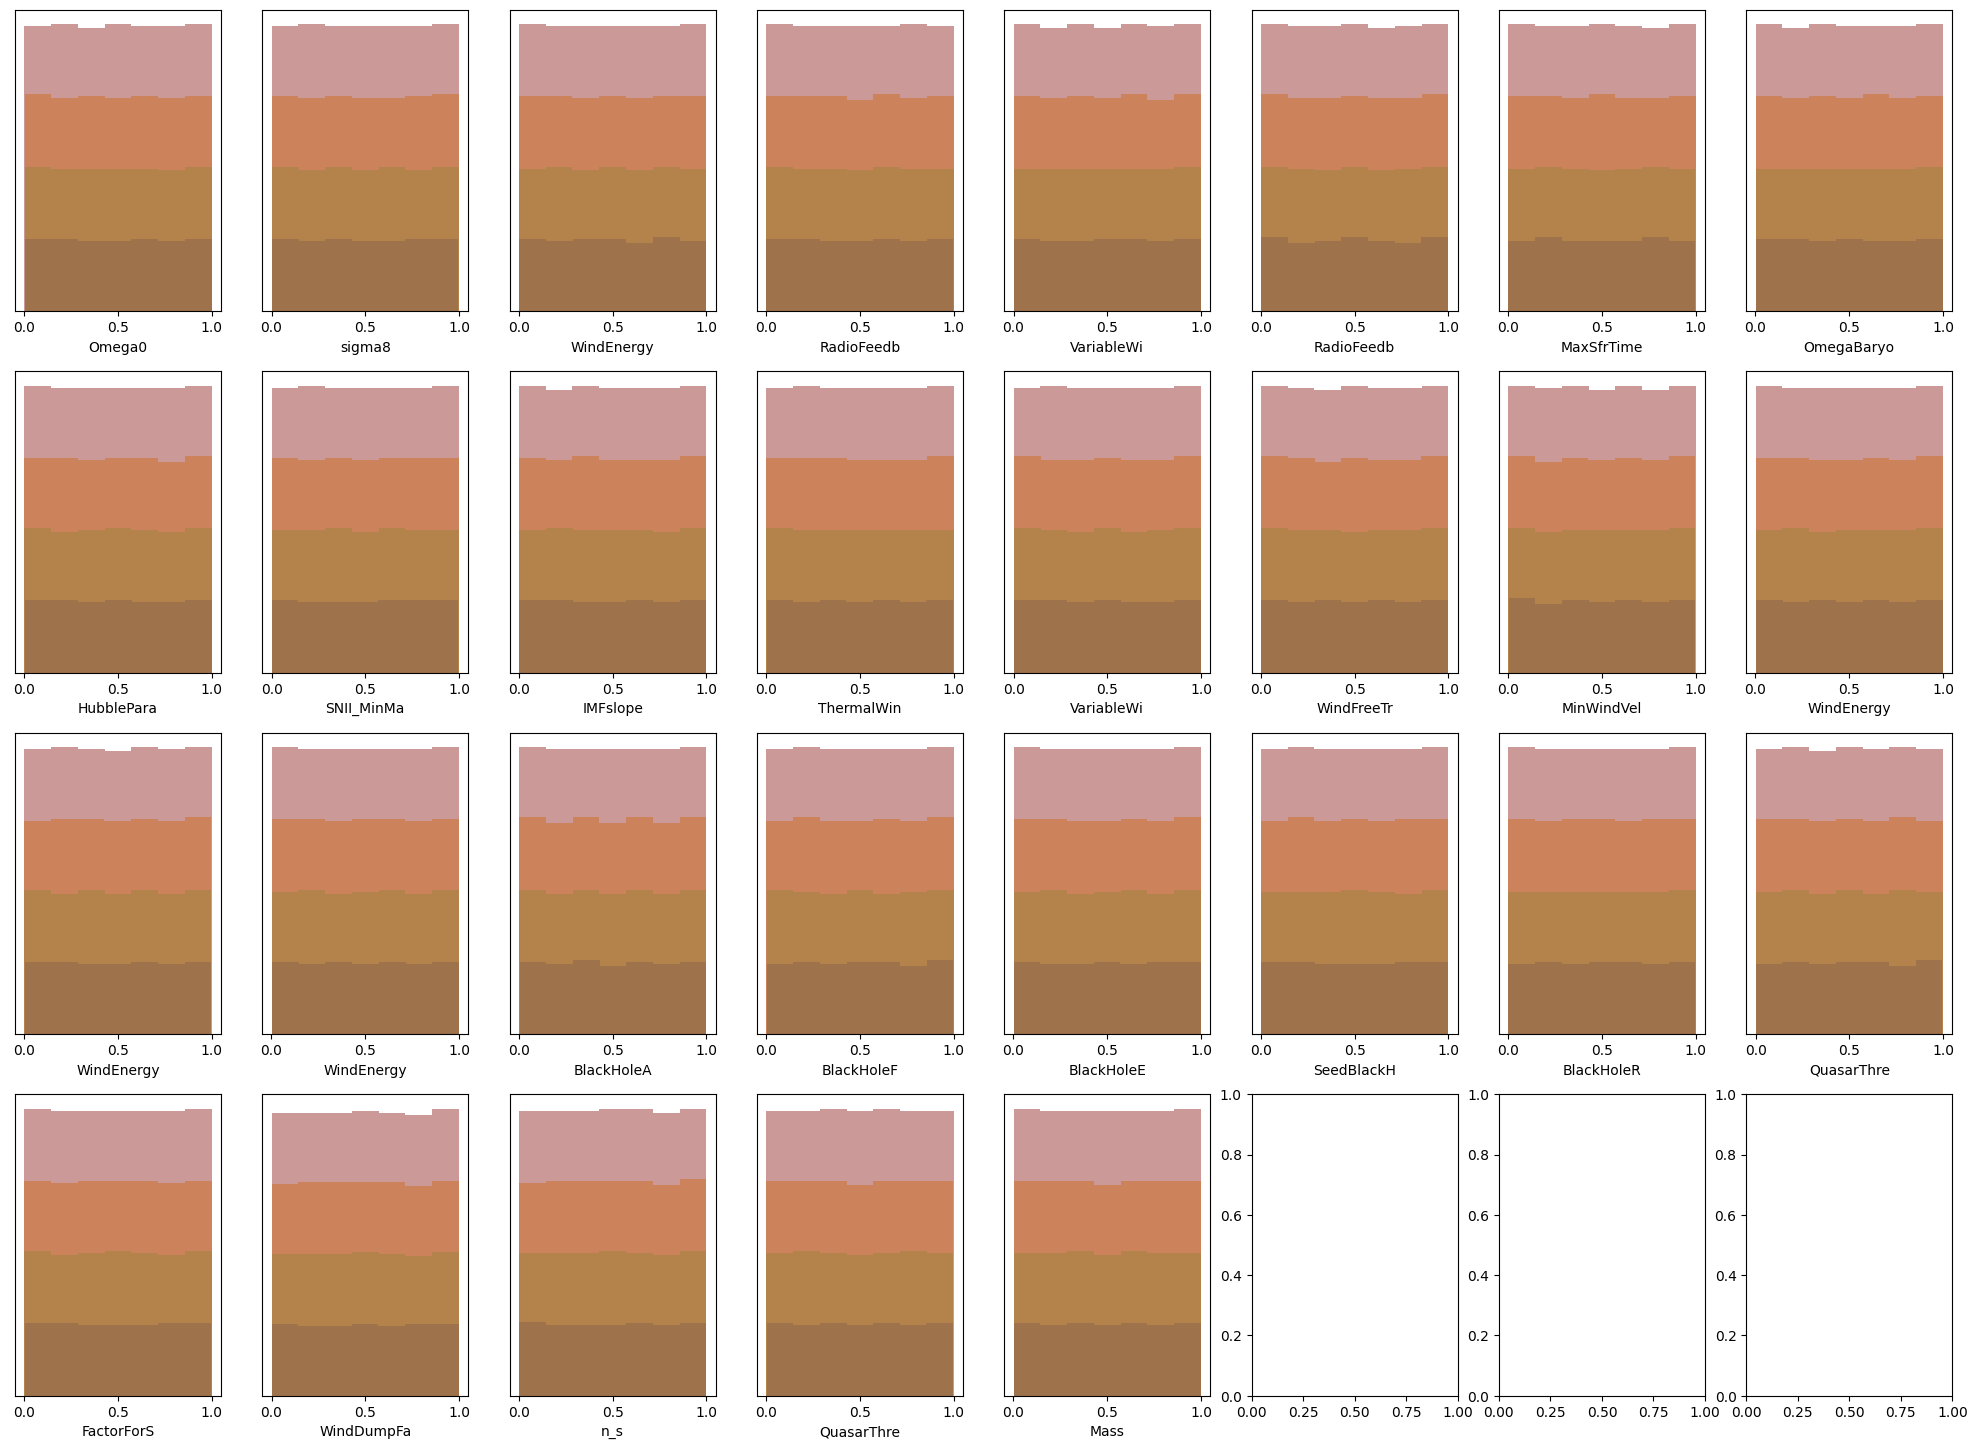

In [276]:
fig, axs = plt.subplots(ncols=8, nrows=4, figsize=(25, 18))
cs = plt.cm.jet(np.linspace(0.2, 1, 4))
for j in range(4):
    theta = theta_reg[:256*(j+1)]

    for i in range(32):
        if i<29:
            if i<28:
                axs[i//8, i%8].hist(theta[:, i], color=cs[j], alpha=0.4, bins=7)
                axs[i//8, i%8].set_yticks([])
                axs[i//8, i%8].set_xlabel(df.loc[i, 'ParamName'][:10])

            else:
                axs[i//8, i%8].hist(theta[:, i], color=cs[j], alpha=0.4, bins=7)
                axs[i//8, i%8].set_yticks([])
                axs[i//8, i%8].set_xlabel('Mass')
            axs[i//8, i%8].set_yticks([])
